In [2]:
# Configure the Jupyter notebook to output multiple lines of the output of the cell
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"
# Import global packages
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import networkx as nx
# Include project functions to system path
import project_path
# Import project functions from utils folder
from util.horpca import horpca
from util.srpg import srpg_nnfold_modified as nnfold
from util.srpg import gmlsvd
from util.srpg import srpg_td_a as tda
from util.t2m import t2m
from util.m2t import m2t
from util.hosvd import hosvd
from util.T_rank import T_rank
from util.geoTL import geoTL
from util.geoTL import initialize_nograd
from util.update_Sigma import fn_val as fnval_Sigma
from util.generate_data import generate_low_rank_data
from util.contaminate_data import contaminate_signal
from util.fn_vals import fn_val_L
from util.fn_vals import fn_val_G

import time

### Experiment 1 (On Synthetic data)
We construct the low-rank tensor $X_o$ of rank (5x5x5) and size (50,50,20). We then corrupt $\rho_n$ fraction of the tensor elements of $X$ with additive noise. We then randomly select the fraction $\rho_o$ of the corrupted tensor elements as observed elements. We call the resulting tensor $X$. 

We try to obtain the low-rank tensor $X_o$ from $X$ with HoRPCA. We observe the performance of the algorithm by calculating the error ${\|X-X_o\|}/{\|X_o\|}$ and the iteration counts of the algorithm for varying the fraction $\rho_o$ from $0.05$ to $1$ and plotting the results.

$\rho_n$: Fraction of the tensor elements corrupted by uniform additive iid uniform noise $T= U(-M,M)$.  
$$\rho_n =\{0.1, 0.25\}$$ 

$M$: Magnitude of the noise.
$$M=1$$ 

$\rho_o$: Ratio of the observed elements compared to the total matrix size.

Experiment is repeated 5 times for each trial. Mean statistics are plotted.

In [4]:
dim = (50, 50, 20)
rank = (5,5,5)
rho_n = [0.1,0.25]
M=0.01
trial_repeat=1

rho_o =[0.01]+ [(i+1)/20 for i in range(20)]

## Bookkeeping values

#err_vec = [[[None]*trial_repeat ]*len(rho_o)]*len(rho_n)
error_arr = np.zeros( (len(rho_n),len(rho_o),trial_repeat) ) 
mean_err_arr = np.zeros((len(rho_n),len(rho_o)) )
iter_arr =  np.zeros( (len(rho_n),len(rho_o),trial_repeat) ) 
mean_iter_arr = np.zeros((len(rho_n),len(rho_o)) )
trank_vec= np.zeros( (len(rho_n),len(rho_o),trial_repeat) )
mean_trank_vec = np.zeros((len(rho_n),len(rho_o)) )

for j in range(len(rho_n)):
    for i in range(len(rho_o)):
        for k in range(trial_repeat):
            X_o = generate_low_rank_data(dim,rank)
            M = (X_o.max()-X_o.min())
            X = contaminate_signal(X_o, noise_rate=rho_n[j], noise_type='bernoulli',
                                M=M, obs_ratio=rho_o[i])
                                
            L, obj_val, terms, lam_val, iter = horpca(X, err_tol=10**-5, max_iter=100, verbose=True)
            error_arr[j,i,k] = np.linalg.norm(L-X_o)/np.linalg.norm(X_o) 
            iter_arr [j,i,k] = iter
        mean_err_arr[j,i]= error_arr[j,i].sum()/len(error_arr[j,i])
        mean_iter_arr[j,i]= iter_arr[j,i].sum()/len(iter_arr[j,i])




Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Converged!
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Max Iter
Converged!


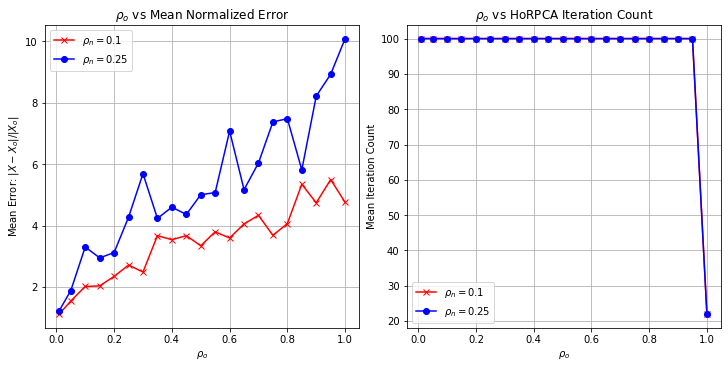

In [5]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5), layout='constrained');
ax1.plot(rho_o,mean_err_arr[0,:], marker='x', color='red', label=r'$\rho_n=0.1$');
ax1.plot(rho_o,mean_err_arr[1,:], marker='o', color='blue', label=r'$\rho_n=0.25$');
ax1.set_title(r'$\rho_o$ vs Mean Normalized Error');
ax1.set_xlabel(r'$\rho_o$');
ax1.set_ylabel(r'Mean Error: ${\|X-X_o\|}/{\|X_o\|}$');
ax1.grid(True);
ax1.legend();
ax2.plot(rho_o,mean_iter_arr[0], marker='x', color='red', label=r'$\rho_n=0.1$');
ax2.plot(rho_o,mean_iter_arr[1], marker='o', color='blue', label=r'$\rho_n=0.25$');
ax2.set_title(r'$\rho_o$ vs HoRPCA Iteration Count');
ax2.set_xlabel(r'$\rho_o$');
ax2.set_ylabel(r'Mean Iteration Count');
ax2.grid(True);
ax2.legend();

##### Questions
- Neden M buyukken $\rho_o$ arttikca errorun artma egilimi var?
- Relative Error 1 den basliyor?
- Ben M i cok yukselttigimde algoritmanin performansi hem error acisindan hem iteration acisindan baya dusuyor. Oysa sparse part'i ayirt etmek daha kolaylasmali. Bunu nasil ayirt ederiz? Information theory ile baglantisi nedir?

### Experiment 2 (On synthetic DATA)
I again worked with the same sythetic data but with different corruption measures. Now we fix the ratio of the observed elements $(\rho_o)$ to 1. I vary the ratio of the corrupted elements $(\rho_n)$ from 1% to 40% just like in the paper.

I again plot the same metrics as experiment 2.

$(\rho_o=1)$: Ratio of the observed elements.

$\rho_n \in [0.01,0.4]$: Ratio of the corrupted elements.

In [49]:
dim = (50, 50, 20)
rank = (5,5,5)
rho_n = [0.01]+[(_+1)/80 for _ in range(32)]
#M=1
trial_repeat=10
rho_o =1

## Bookkeeping values
exp2_err_vec1 = np.zeros(shape=(len(rho_n),trial_repeat))
exp2_mean_err_vec1 = np.zeros(shape=len(rho_n))
exp2_iter_vec1 =  np.zeros(shape=(len(rho_n),trial_repeat))
exp2_mean_iter_vec1 = np.zeros(shape=len(rho_n))

for i in range(len(rho_n)):
    for _ in range(trial_repeat):
        X_o = generate_low_rank_data(dim,rank)
        M = (X_o.max()-X_o.min())/20
        X = contaminate_signal(X_o, noise_rate=rho_n[i], noise_type='bernoulli',
                             M=M, obs_ratio=rho_o)
        #X = contaminate_signal(X_o, noise_type='AWGN', noise_rate=-10, obs_ratio=rho_o)
        L, obj_val, terms, lam_val, iter = horpca(X, err_tol=10**-8, max_iter=300)
        exp2_err_vec1[i,_] = np.linalg.norm(L-X_o)/np.linalg.norm(X_o) 
        exp2_iter_vec1[i,_] = iter
    exp2_mean_err_vec1[i] = exp2_err_vec1[i].sum()/len(exp2_err_vec1[i])
    exp2_mean_iter_vec1[i]= exp2_iter_vec1[i].sum()/len(exp2_iter_vec1[i])

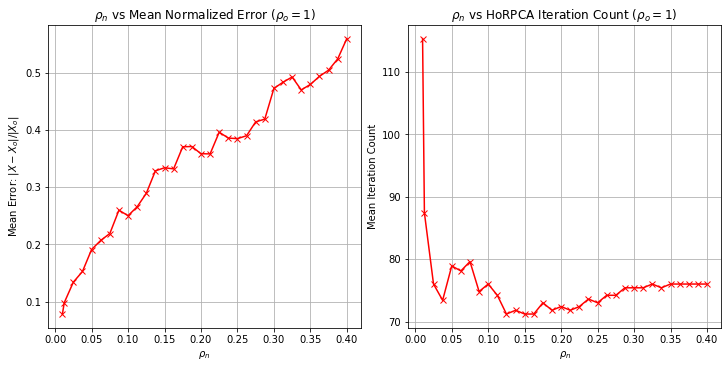

In [50]:
fig3, (ax5,ax6) = plt.subplots(1,2, figsize=(10,5), layout='constrained');
ax5.plot(rho_n,exp2_mean_err_vec1, marker='x', color='red');
ax5.set_title(r'$\rho_n$ vs Mean Normalized Error $(\rho_o=1)$');
ax5.set_xlabel(r'$\rho_n$');
ax5.set_ylabel(r'Mean Error: ${\|X-X_o\|}/{\|X_o\|}$');
ax5.grid(True);
ax6.plot(rho_n,exp2_mean_iter_vec1, marker='x', color='red');
ax6.set_title(r'$\rho_n$ vs HoRPCA Iteration Count $(\rho_o=1)$');
ax6.set_xlabel(r'$\rho_n$');
ax6.set_ylabel(r'Mean Iteration Count');
ax6.grid(True);

In [72]:
rho_o = (np.arange(10)+1)/10
rho_n = (np.arange(40)+1)/40
dim = (50,50,20)
ranks = [(2,5,5), (11,7,8), (21,23,9)]
trial_repeat = 5
ten2x5x5  = [generate_low_rank_data(dim,ranks[0]) for _ in range(trial_repeat)]
ten11x7x8 = [generate_low_rank_data(dim,ranks[1]) for _ in range(trial_repeat)]
ten21x23x9= [generate_low_rank_data(dim,ranks[2]) for _ in range(trial_repeat)]



In [73]:
errs = np.zeros((3,len(rho_o),len(rho_n),trial_repeat))
normalized_rank_results =  np.zeros((3,len(rho_o),len(rho_n),trial_repeat))

for o in range(len(rho_o)):
    for n in range(len(rho_n)):
        for t in range(trial_repeat):
# -------- (2x5x5) -------
            M = (ten2x5x5[t].max()-ten2x5x5[t].min())/20
            X = contaminate_signal(ten2x5x5[t], noise_rate=rho_n[n], noise_type='bernoulli',
                                M=M, obs_ratio=rho_o[o])

            L, obj_val, terms, lam_val, iter = horpca(X, err_tol=10**-6, max_iter=200)
            errs[0,o,n,t] =  np.linalg.norm(L-ten2x5x5[t])/np.linalg.norm(ten2x5x5[t])
            a,normalized_rank_results[0,o,n,t] = T_rank(L)

# -------- (11x7x8) -------
            M = (ten11x7x8[t].max()-ten11x7x8[t].min())/20
            X = contaminate_signal(ten11x7x8[t], noise_rate=rho_n[n], noise_type='bernoulli',
                                M=M, obs_ratio=rho_o[o])

            L, obj_val, terms, lam_val, iter = horpca(X, err_tol=10**-6, max_iter=200)
            errs[1,o,n,t] = np.linalg.norm(L-ten11x7x8[t])/np.linalg.norm(ten11x7x8[t])
            a,normalized_rank_results[1,o,n,t] = T_rank(L)

# -------- (21x23x9) -------
            M = (ten21x23x9[t].max()-ten21x23x9[t].min())/20
            X = contaminate_signal(ten21x23x9[t], noise_rate=rho_n[n], noise_type='bernoulli',
                                M=M, obs_ratio=rho_o[o])

            L, obj_val, terms, lam_val, iter = horpca(X, err_tol=10**-6, max_iter=200)
            errs[2,o,n,t] = np.linalg.norm(L-ten21x23x9[t])/np.linalg.norm(ten21x23x9[t])
            a,normalized_rank_results[2,o,n,t] = T_rank(L)







In [81]:
success_thr = 0.4
# Find threshold on the percentage of corruptions for each fraction of observations 
# under which perfect reconstruction is possible
max_errs = errs.max(3)
mean_errs= errs.mean(3)
max_successful  = (max_errs < success_thr) 
mean_successful = mean_errs < success_thr
max_successful.size
max_successful.sum()
mean_successful.size
mean_successful.sum()

errs[2,...].min()

errs[2,0,24,:]

1200

192

1200

263

0.07669308638852602

array([0.95263891, 0.94591336, 0.94972614, 0.94717405, 0.95167524])

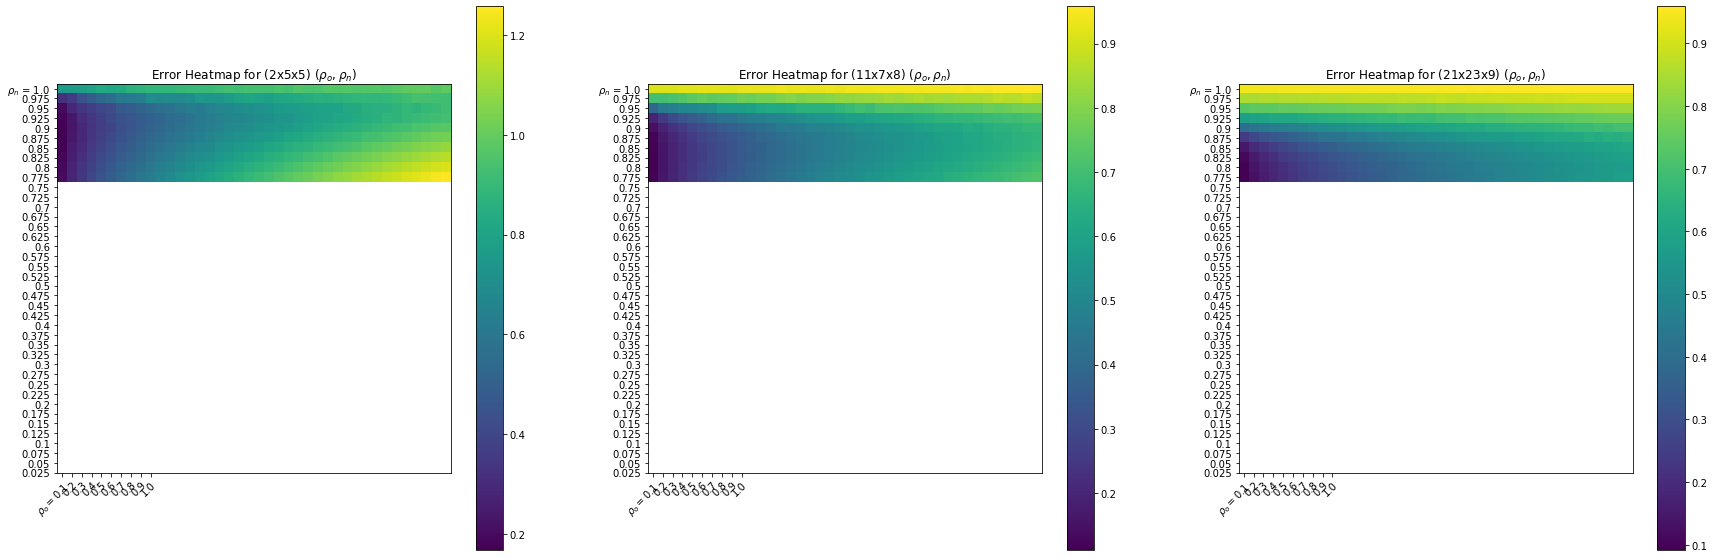

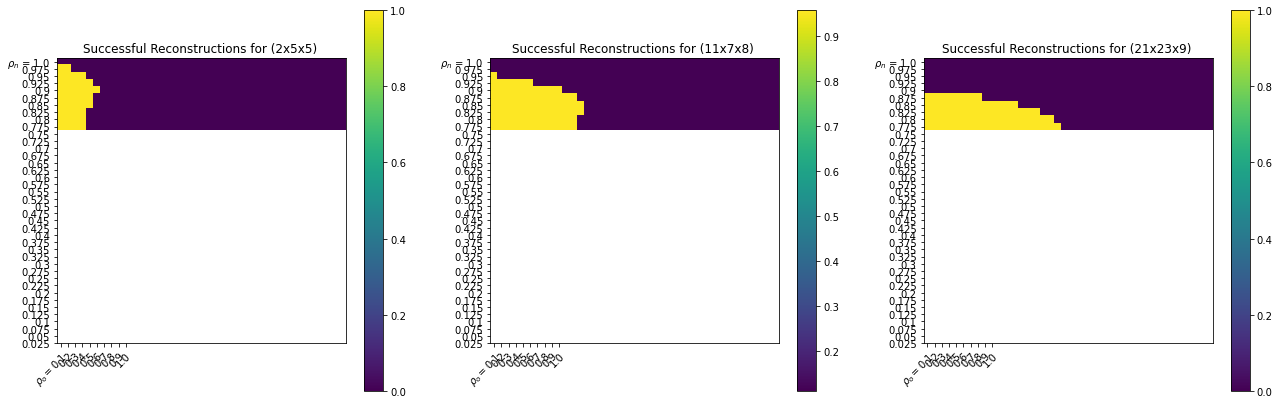

In [84]:

fig_map, (axm1, axm2, axm3) = plt.subplots(1, 3, figsize=(30,10));


xaxis = [rf'$\rho_o = {rho_o[0]}$'] + [f'{o}' for o in rho_o[1:]]
yaxis = ([f'{n}' for n in rho_n[:-1]] + [rf'$\rho_n$ = {rho_n[-1]}'] ) [::-1]
# ----------- 2x5x5 
im1 = axm1.imshow(max_errs[0,...]);
axm1.set_xticks(np.arange(len(rho_o)), xaxis);
axm1.set_yticks(np.arange(len(rho_n)), yaxis);
axm1.set_title(r"Error Heatmap for (2x5x5) $(\rho_o, \rho_n)$")
plt.setp(axm1.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor");
cbar1 = axm1.figure.colorbar(im1, ax=axm1);
cbar1.ax.set_ylabel("",rotation=-90, va="bottom");


# ----------- 11x7x8
im2 = axm2.imshow(max_errs[1,...]);
axm2.set_xticks(np.arange(len(rho_o)), xaxis);
axm2.set_yticks(np.arange(len(rho_n)), yaxis);
axm2.set_title(r"Error Heatmap for (11x7x8) $(\rho_o, \rho_n)$")
plt.setp(axm2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor");
cbar2 = axm2.figure.colorbar(im2, ax=axm2);
cbar2.ax.set_ylabel("", rotation=-90, va="bottom");

# -------- (21x23x9) -------
im3 = axm3.imshow(max_errs[2,...]);
axm3.set_xticks(np.arange(len(rho_o)), xaxis);
axm3.set_yticks(np.arange(len(rho_n)), yaxis);
axm3.set_title(r"Error Heatmap for (21x23x9) $(\rho_o, \rho_n)$")
plt.setp(axm3.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor");
cbar3 = axm3.figure.colorbar(im3, ax=axm3);
cbar3.ax.set_ylabel("", rotation=-90, va="bottom");



fig_thr, (axn1, axn2, axn3) = plt.subplots(1, 3, figsize=(22,7));

# ----------- 2x5x5 
imn1 = axn1.imshow(max_successful[0,...]);
axn1.set_xticks(np.arange(len(rho_o)), xaxis);
axn1.set_yticks(np.arange(len(rho_n)), yaxis);
axn1.set_title(r"Successful Reconstructions for (2x5x5) ")
plt.setp(axn1.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor");
cbarn1 = axn1.figure.colorbar(imn1, ax=axn1);
cbarn1.ax.set_ylabel("",rotation=-90, va="bottom");


# ----------- 11x7x8
imn2 = axn2.imshow(max_successful[1,...]);
axn2.set_xticks(np.arange(len(rho_o)), xaxis);
axn2.set_yticks(np.arange(len(rho_n)), yaxis);
axn2.set_title(r"Successful Reconstructions for (11x7x8) ")
plt.setp(axn2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor");
cbarn2 = axn2.figure.colorbar(im2, ax=axn2);
cbarn2.ax.set_ylabel("", rotation=-90, va="bottom");

# -------- (21x23x9) -------
imn3 = axn3.imshow(max_successful[2,...]);
axn3.set_xticks(np.arange(len(rho_o)), xaxis);
axn3.set_yticks(np.arange(len(rho_n)), yaxis);
axn3.set_title(r"Successful Reconstructions for (21x23x9) ")
plt.setp(axn3.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor");
cbarn3 = axn3.figure.colorbar(imn3, ax=axn3);
cbarn3.ax.set_ylabel("", rotation=-90, va="bottom");


